# Actual power consumption and estimations

For 11.5 MB data, batchsize 32, running on 1 GPU, \
time = 1 hour 40 min \
nvidia-smi GPU energy consumption = 1581170.0899999999 W = 0.43921391388888886 kWh \
GPU + CPU energy consumption = 0.5627291196798899 kWh \
power monitor reading = 0.6127022608333333 kWh

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [36]:
url = "nvidia/nvidia_power_pretrain_11mb.csv"
df_orig = pd.read_csv(url)

In [37]:
#it is using one gpu only

In [38]:
df_orig.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df_orig.timestamp]
df = df_orig.loc[df_orig[" utilization.gpu [%]"] > 0] #isolating training 

In [39]:
time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
#print("Total time in seconds: {}".format(time_interval.total_seconds()))
total_time = time_interval.total_seconds()
print("seconds: {}".format(total_time))
print ("training hours: {}".format(total_time/3600))
print(df.iloc[-1].timestamp, df.iloc[0].timestamp)

seconds: 5991.57
training hours: 1.6643249999999998
2020-06-17 00:18:51.137000 2020-06-16 22:38:59.567000


In [40]:
time_interval_cpu = df_orig.iloc[-1].timestamp - df_orig.iloc[0].timestamp
total_time_cpu = time_interval_cpu.total_seconds()
print("Seconds: {}".format(total_time_cpu))
print ("Hours: {}".format(total_time_cpu/3600))

Seconds: 6004.669
Hours: 1.6679636111111111


In [41]:
mean_power =df[' power.draw [W]'].mean() 
total_power = mean_power * total_time 
sum_power = df_orig[' power.draw [W]'].sum() # total power during the time code is running
gpu_util = df[' utilization.gpu [%]'].mean()
memory_util = df[' utilization.memory [%]'].mean()
memory_used = df[' memory.used [MiB]'].mean()
print('{} total from mean \n{} summed power'.format(total_power,sum_power))
print('in kWh ', sum_power / (1000 * 3600))
print("GPU utilisation: ", gpu_util)

1516541.3808476038 total from mean 
1581170.0899999999 summed power
in kWh  0.43921391388888886
GPU utilisation:  98.41828958509737


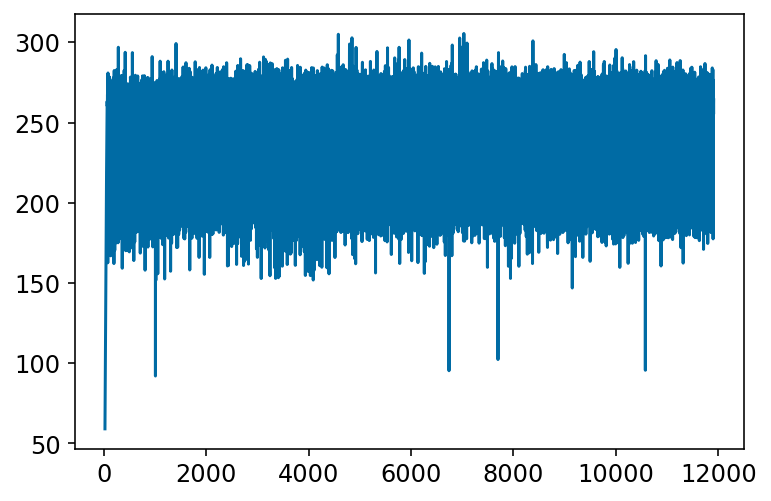

In [42]:
df[" power.draw [W]"].plot()

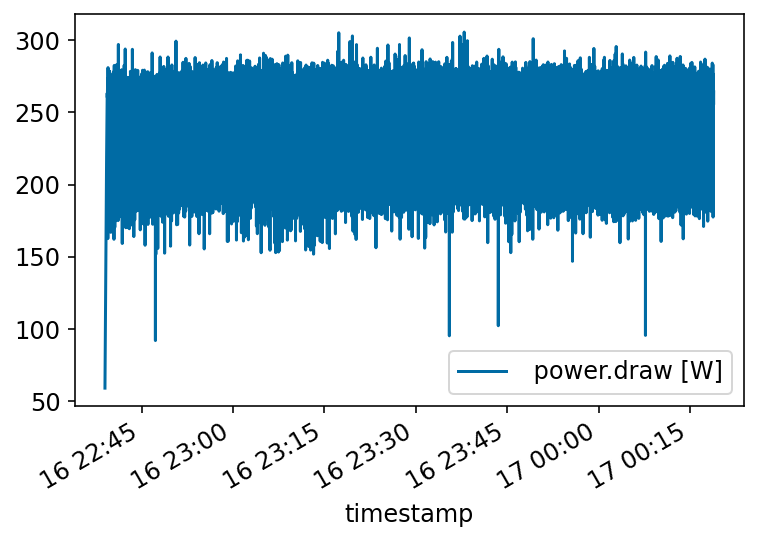

In [43]:
df.plot(x= "timestamp",y = " power.draw [W]")

In [44]:
df[' power.draw [W]'].describe() 

count    5905.000000
mean      253.112520
std        32.139627
min        59.100000
25%       252.170000
50%       265.390000
75%       272.700000
max       305.490000
Name:  power.draw [W], dtype: float64

In [45]:
print("total power consumption: {} W".format(total_power))

total power consumption: 1516541.3808476038 W


In [46]:
t = total_power / (1000 * 60 *60)
print("total power consumption: {} kWh".format(t))

total power consumption: 0.42126149467988994 kWh


As per output from run_pretraining \
global step per second = 2.12.... \
examples/sec = global step * batch size = 67/68 \
the dataset has 101103 instances \
time to process = 101103 / 67 \
per epoch

In [47]:
dataset_size = 101103
estimated_time = 101103 /67
total_est_time = estimated_time * 3 #3 epochs
print(total_est_time)

4527.0


In [48]:
samples_per_sec = (dataset_size * 3) / total_time
time_per_sample = total_time / (dataset_size * 3)

print("Samples processed per sec ", samples_per_sec)
print("Time to process one sample ", time_per_sample)

Samples processed per sec  50.6226247878269
Time to process one sample  0.019754013234028662


In [49]:
# approx flops using the ai and compute equation
# Number of GPUs * (peta-flops/GTX580) * days trained * estimated utilization
gtx1080TFLOPS = 11.34  # https://www.techpowerup.com/gpu-specs/geforce-gtx-1080-ti.c2877
TFLOPs = 1 * gtx1080TFLOPS *  total_time * gpu_util
PFLOPs = TFLOPs/ 1000
PFLOPs_per_example= PFLOPs/ (dataset_size* 3) #3 epochs

In [50]:
PFLOPs_per_example

0.022046731250556992

Add CPU TDP 85W

In [51]:
cpu_energy = 85 * total_time_cpu

In [52]:
total_energy = total_power + cpu_energy

In [53]:
print (total_energy)

2026938.2458476038


In [54]:
total_energy_kwh = total_energy / (1000 * 3600)
total_energy_kwh

0.5630384016243344

## from the power monitor

In [55]:
print (df.iloc[-1].timestamp, df.iloc[0].timestamp)
print (df_orig.iloc[-1].timestamp, df_orig.iloc[0].timestamp)

2020-06-17 00:18:51.137000 2020-06-16 22:38:59.567000
2020-06-17 00:18:51.139000 2020-06-16 22:38:46.470000


In [56]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [57]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [58]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

/Users/shivangi/Documents/power_monitor/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


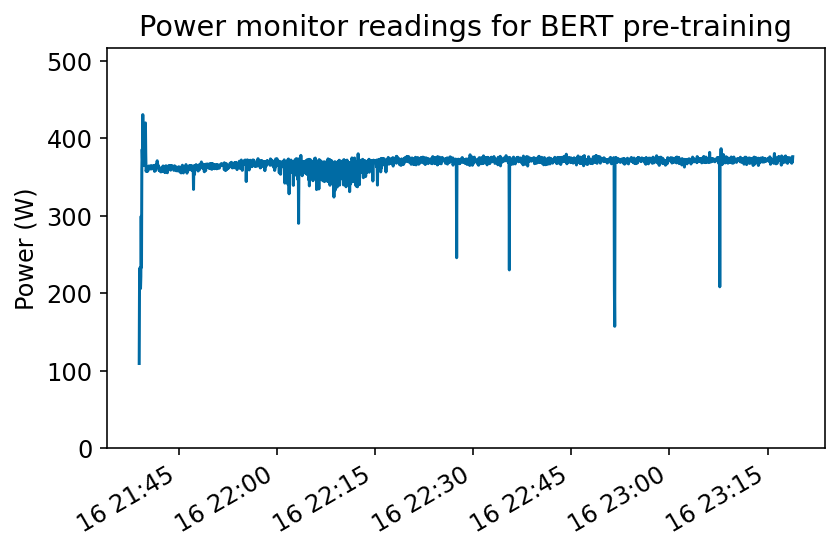

In [59]:
y_max = subset_df['power_consumption'].max() * 1.2
ax =subset_df[(power_monitor_df != 0).all(1)].plot(ylim=(0,y_max), legend=False)
ax.set_title("Power monitor readings for BERT pre-training")
ax.set_ylabel('Power (W)')
ax.set_xlabel('')
plt.tight_layout()
ax.figure.savefig("viz/pm_BERT_pretrain.png", dpi=300)

In [60]:
from statsmodels.tsa.stattools import adfuller
def testStationary(series):
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [61]:
testStationary(subset_df["power_consumption"])

ADF Statistic: -5.020088
p-value: 0.000020
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [62]:
mean_power_monitor = subset_df["power_consumption"].mean()
mean_power_monitor

367.98934584584583

In [63]:
total_power_monitor = mean_power_monitor * total_time

In [64]:
print("total power consumption from nvidia-smi: {} W".format(total_power))

total power consumption from nvidia-smi: 1516541.3808476038 W


In [65]:
total_power_monitor - total_energy

177895.67904199054

In [66]:
total_pm_kwh = total_power_monitor /( 1000 * 3600)

In [67]:
print (total_energy_kwh, total_pm_kwh)

0.5630384016243344 0.6124538680248873


Idea: can I get sample size in number of examples from the dataset size in MB


In [68]:
wiki_file_size=11.5 #MB

In [69]:
time_to_process_1MB= total_time / wiki_file_size

In [70]:
time_to_process_1MB

521.0060869565217

In [71]:
data_100MB = 100
time_100MB = time_to_process_1MB * 100
time_100MB

52100.60869565217

In [72]:
words_for_bert = (800 + 2500) #M words

In [73]:
#assuming 10 characters per word
datasize = words_for_bert * 10 # MB

In [74]:
time_bert = time_to_process_1MB * datasize
time_bert #seconds

17193200.869565215

In [75]:
time_bert / (3600 * 24) #days with 1 gpu

198.9953804347826

In [76]:
(time_bert * mean_power) / (1000 * 3600) #kWh

1208.8373325596842

In [77]:
wiki_16gb = 16 * 1000 #mb
time_16gb = wiki_16gb * time_to_process_1MB 
time_16gb / (3600 * 24)

96.48260869565216

In [78]:
time_16gb * mean_power / (1000 * 3600)

586.1029491198468

## CO2e values from MLCO2 project

In [79]:
df_co2 = pd.read_csv("results/co2data.csv")
df_co2.head()

,provider,providerName,offsetRatio,region,regionName,country,state,city,impact,source,comment,country_code,continent,continent_name
0,gcp,Google Cloud Platform,100,asia-east1,NaN,Taiwan,NaN,Changhua County,585.0,"measured on September 4, 2020 between 6 and 7...",NaN,TW,AS,Asia
1,gcp,Google Cloud Platform,100,asia-east2,NaN,China,NaN,Hong Kong,702.0,https://www.sciencedirect.com/science/article/...,NaN,CN,AS,Asia
2,gcp,Google Cloud Platform,100,asia-northeast1,NaN,Japan,NaN,Tokyo,516.0,https://www.sciencedirect.com/science/article/...,NaN,JP,AS,Asia
3,gcp,Google Cloud Platform,100,asia-northeast2,NaN,Japan,NaN,Osaka,516.0,https://www.fepc.or.jp/library/pamphlet/pdf/04...,NaN,JP,AS,Asia
4,gcp,Google Cloud Platform,100,asia-south1,NaN,India,NaN,Mumbai,708.0,https://www.carbonfootprint.com/docs/2020_07_e...,Climate Transparency (2019 Report),IN,AS,Asia


In [80]:
maximpact = df_co2.loc[df_co2['impact'].idxmax()]
minimpact = df_co2.loc[df_co2['impact'].idxmin()]

In [81]:
print(f'min impact in {minimpact.region}, {minimpact.city} producing {minimpact.impact * total_pm_kwh} gCOe/kWh')

min impact in europe-west6, Zürich producing 6.7369925482737605 gCOe/kWh


In [82]:
print(f'max impact in {maximpact.region}, {maximpact.city} producing {maximpact.impact * total_pm_kwh} gCOe/kWh')

max impact in southafricanorth, Pretoria producing 568.3571895270954 gCOe/kWh


In [83]:
df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

253.0

In [84]:
df_co2.loc[df_co2.country == 'USA'].impact.mean()

395.61578947368423

In [85]:
df_co2.loc[df_co2.country == 'India'].impact.mean()

708.0